In [1]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import torch
import matplotlib.pyplot as plt

In [2]:
rand_feature_map = torch.normal(0, 1, (10, 512, 512))

In [3]:
X = np.random.rand(1_000)
y = X >= .5
X = np.clip(X + (np.random.rand(1_000) - 0.5)/4, 0, 1)

In [4]:
lr = LogisticRegression()
lr.fit(X.reshape(-1, 1), y)

LogisticRegression()

In [6]:
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(X, y)

IsotonicRegression(out_of_bounds='clip')

In [7]:
class TorchLogisticRegression(torch.nn.Module):
    def __init__(self, lr: LogisticRegression):
        super().__init__()
        self._coef = torch.from_numpy(lr.coef_)
        self._intercept = torch.from_numpy(lr.intercept_)
    def forward(self, probs):
        return torch.sigmoid(probs*self._coef + self._intercept)

In [8]:
class TorchIsotonicRegression(torch.nn.Module):
    def __init__(self, ir: IsotonicRegression):
        super().__init__()
        self.x_vals = torch.from_numpy(ir.f_.x)
        self.y_vals = torch.from_numpy(ir.f_.y)
    def forward(self, inputs):
        masks = []
        for x_val, y_val in zip(self.x_vals, self.y_vals):
            masks.append(torch.where(inputs >= x_val, y_val, 0.))
        vals, _ = torch.max(torch.stack(masks, dim=0), dim=0)
        return vals 

In [9]:
torchLR = TorchLogisticRegression(lr)
torchIR = TorchIsotonicRegression(ir)

### LogisticRegression Test

In [10]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1, 1)

In [11]:
%%timeit
res = lr.predict_proba(xs)[:, 1]
res = res.reshape(rand_feature_map.shape)

31.2 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
res = torchLR.forward(rand_feature_map)
_ = res.numpy()

7.69 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
torch_res = torchLR.forward(rand_feature_map)
torch_res = torch_res.numpy()

In [14]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1, 1)
sklearn_res = lr.predict_proba(xs)[:, 1]
sklearn_res = sklearn_res.reshape(rand_feature_map.shape)

In [15]:
np.allclose(torch_res, sklearn_res)

True

### IsotonicRegression Test

In [16]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1)

In [17]:
%%timeit
res = ir.predict(xs)
res = res.reshape(rand_feature_map.shape)

60.4 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
res = torchIR.forward(rand_feature_map)
_ = res.numpy()

117 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
torch_res = torchIR.forward(rand_feature_map)
torch_res = torch_res.numpy()

In [20]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1)
sklearn_res = ir.predict(xs)
sklearn_res = sklearn_res.reshape(rand_feature_map.shape)

In [64]:
ir.f_.y[1:] - ir.f_.y[:-1], ir.f_.x[1:] - ir.f_.x[:-1]

(array([0.        , 0.08333333, 0.        , 0.07993197, 0.        ,
        0.17006803, 0.        , 0.10784314, 0.        , 0.05882353,
        0.        , 0.06521739, 0.        , 0.23023715, 0.        ,
        0.12121212, 0.        , 0.00925926, 0.        , 0.07407407,
        0.        ]),
 array([3.79625328e-01, 2.45735899e-03, 1.07856748e-02, 5.75513368e-04,
        4.89614198e-02, 1.39243575e-03, 2.97546258e-04, 4.05579307e-04,
        5.89870871e-02, 6.04561218e-04, 1.07226790e-03, 1.00392629e-03,
        3.33646426e-02, 4.45536055e-04, 3.88950619e-02, 4.21454077e-04,
        7.64076220e-03, 2.97197832e-03, 2.61900351e-02, 8.59278228e-04,
        3.83042553e-01]))

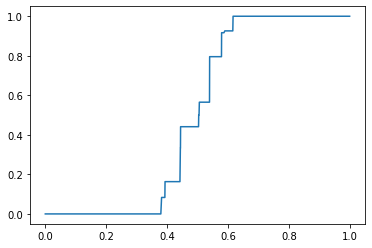

In [57]:
plt.plot(ir.f_.x, ir.f_.y)